<a href="https://colab.research.google.com/github/stefanogiagu/hachathons/blob/main/notebooks/ML_INFN_Hackhathon2023Adv_Transformer_Solution.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#ML-INFN Hackathon: Advanced Level
##Hands-on on Transformers

In this hands-on session, we will try to implement a transformer architecture and to train it for a tipical high energy physics task: jet tagging (e.g. classification of jets originating from different particles: *gluons, quarks, Ws, Zs, and top quarks*.

**Physics context:** <p>
At the extreme energies of the Large Hadron Collider, massive particles can be produced with such high Lorentz boost that their decays into hadrons (hadron jets) are collimated in such a way that the resulting particles overlap. Deducing whether the substructure of an observed jet is due to a single low-mass particle or to multiple decay objects of a high-mass particle is an important problem in LHC data analysis. Traditional approaches are based on high-level observables built from theoretical models of energy deposition in calorimeters and charged tracks parameters reconsrtcuted in the inner tracker, but the complexity of the data makes this task an excellent candidate for the application of deep learning tools. The jet constituents can be in fact represented either as 2D or 3D images,lending itself to the natural application of image classification techniques (CNN, ViT etc.), or as pointclouds/graphs, that can be classified with GNNs, or as sequences, that can be analysed by RNNs or Transformers.


**Dataset:** <p>
The dataset is the *JetDataset* from J. Duarte et al.


**Transfortmer Architecture:** <p>

We implements the original transformer architecture of *A.Vaswani et al. “Attention is All You Need” (2017) [arXiv:1706.03762](https://arxiv.org/abs/1706.03762)*, by using only the transformer-encoder part, with multi-head attentions+MLP blocks. We also adopt a pre-layer normalization (in addition to the original post-layer normalization) as suggested by *R.Xiong et al. "On Layer Normalization in the Transformer Architecture" (2020) [pdf](http://proceedings.mlr.press/v119/xiong20b/xiong20b.pdf)*.  

The implementation is done using pure [PyTorch](https://pytorch.org) APIs.

For infos, latest version of the notebook, etc., contact Stefano Giagu: email: <stefano.giagu@uniroma1.it>, web: [https://www.giagu.it](https://www.giagu.it)

In [ ]:
import os, subprocess, re
os.environ["CUDA_VISIBLE_DEVICES"] = ''.join(re.findall("UUID: (MIG-[^)]+)\)", str(subprocess.check_output(["nvidia-smi", "-L"]), 'ascii')))

In [ ]:
#imports
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import h5py
import glob

import torch
import torchvision
print(torch.__version__)
print(torchvision.__version__)

import torch.nn as nn
import torch.nn.functional as F

2.1.0
0.16.0


In [ ]:
# dataset download
# we'll clone a github repository from M. Pierini containing the dataset
! git clone https://github.com/pierinim/tutorials.git
! ls tutorials/Data/JetDataset/

fatal: destination path 'tutorials' already exists and is not an empty directory.
jetImage_7_100p_0_10000.h5	jetImage_7_100p_50000_60000.h5
jetImage_7_100p_10000_20000.h5	jetImage_7_100p_60000_70000.h5
jetImage_7_100p_30000_40000.h5	jetImage_7_100p_70000_80000.h5
jetImage_7_100p_40000_50000.h5	jetImage_7_100p_80000_90000.h5


In [ ]:
# define device to use (cpu/gpu)
if torch.cuda.is_available():
  print('# of GPUs available: ', torch.cuda.device_count())
  print('First GPU type: ',torch.cuda.get_device_name(0))
device = ('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Computation device: {device}\n")

# of GPUs available:  1
First GPU type:  NVIDIA A100 80GB PCIe MIG 1g.10gb
Computation device: cuda



## Data Handling

The dataset consists of a list of jets. For each jet, we have up to 100 particles (zero-padding is used in case a jet has less than 100 particles).

For each particle, we have 16 features:

* the four-momentum in cartesian coordinates $(p_x,p_y,p_z,E)$
* the energy divided by the jet energy ($E_{rel}$)
* the transverse momentum ($p_T$), i.e. the momentum projected on the plane transverse to proton beams
* the momentum transverse to the jet direction ($p_{Trel}$)
* the pseudorapidity ($\eta$), a function of the polar angle (see https://en.wikipedia.org/wiki/Pseudorapidity)
* the pseudorapidity relative to the jet direction ($\eta_{rel}$)
* the pseudorapidity relative to the jet direction ($\eta_{rot}$) after a rotation is applied so that the jet image looks vertical
* the azimuth angle ($\phi$)
* the azimuth angle relative to the jet direction ($\phi_{rel}$)
* the azimuth angle relative to the jet direction ($\phi_{rot}$) after a rotation is applied so that the jet image looks vertical

The ground truth is incorporated in a ['j_g', 'j_q', 'j_w', 'j_z', 'j_t] vector of boolean, taking the form:

* $[1, 0, 0, 0, 0]$ for gluons
* $[0, 1, 0, 0, 0]$ for quarks
* $[0, 0, 1, 0, 0]$ for W bosons (with W  qq)
* $[0, 0, 0, 1, 0]$ for Z bosons (with Z  qq)
* $[0, 0, 0, 0, 1]$ for top quarks (with t  Wq  qqq)

This is what is called 'one-hot' encoding of a discrete label (typical of ground truth for classification problems).

In [ ]:
# data is stored in hirearchical data format (h5), a file format desgined to store and maniuplate large size data structures
# .h5 files can be accesses in python using the h5py library (https://docs.h5py.org/en/stable/)

# read dataset (only 50k events to keep training time ~20' on google colab, better performance can be obtained adding the three commented files
target = np.array([])
p_data = np.array([])
datafiles = [#'tutorials/Data/JetDataset/jetImage_7_100p_80000_90000.h5',
             #'tutorials/Data/JetDataset/jetImage_7_100p_70000_80000.h5',
             #'tutorials/Data/JetDataset/jetImage_7_100p_60000_70000.h5',
             'tutorials/Data/JetDataset/jetImage_7_100p_50000_60000.h5',
             'tutorials/Data/JetDataset/jetImage_7_100p_40000_50000.h5',
             'tutorials/Data/JetDataset/jetImage_7_100p_30000_40000.h5',
             'tutorials/Data/JetDataset/jetImage_7_100p_10000_20000.h5',
             'tutorials/Data/JetDataset/jetImage_7_100p_0_10000.h5']


# let's print what is contained in one of the files:
f = h5py.File(datafiles[0])
print(list(f.keys()))
f.close()

# each file contains different numpy arrays, the ones we are interested in are:
# "jetConstituentsList": containing for each jet, and for each jet constituent particle (up to 100 particles) the 16 features associated to the jet particle
# "jets": containing for each jet several (59) global features of the jet, we are here interested in the elements from -6:-1 that provide a onehot encoding of the jet-type label ['j_g', 'j_q', 'j_w', 'j_z', 'j_t]


#loop over the files and concatenate the content to the p_adat and target arrays
for fileIN in datafiles:
    print("Appending %s" %fileIN)
    f = h5py.File(fileIN) #read the h5 file
    data = np.array(f.get("jetConstituentList")) #jet constituents
    targ = np.array(f.get('jets')[0:,-6:-1])  #select ['j_g', 'j_q', 'j_w', 'j_z', 'j_t] out of the 59 features presents in the container
    p_data = np.concatenate([p_data, data], axis=0) if p_data.size else data
    target = np.concatenate([target, targ], axis=0) if target.size else targ
    del data, targ
    f.close()

print(target.shape, p_data.shape)

p_featurenames = ['j1_px','j1_py','j1_pz','j1_e','j1_erel','j1_pt','j1_ptrel',
 'j1_eta','j1_etarel','j1_etarot','j1_phi','j1_phirel','j1_phirot',
 'j1_deltaR','j1_costheta','j1_costhetarel']

print(p_featurenames)

['jetConstituentList', 'jetFeatureNames', 'jetImage', 'jetImageECAL', 'jetImageHCAL', 'jets', 'particleFeatureNames']
Appending tutorials/Data/JetDataset/jetImage_7_100p_50000_60000.h5
Appending tutorials/Data/JetDataset/jetImage_7_100p_40000_50000.h5
Appending tutorials/Data/JetDataset/jetImage_7_100p_30000_40000.h5
Appending tutorials/Data/JetDataset/jetImage_7_100p_10000_20000.h5
Appending tutorials/Data/JetDataset/jetImage_7_100p_0_10000.h5
(50000, 5) (50000, 100, 16)
['j1_px', 'j1_py', 'j1_pz', 'j1_e', 'j1_erel', 'j1_pt', 'j1_ptrel', 'j1_eta', 'j1_etarel', 'j1_etarot', 'j1_phi', 'j1_phirel', 'j1_phirot', 'j1_deltaR', 'j1_costheta', 'j1_costhetarel']


In [ ]:
# print the information for one of the jets

labels = ['gluon', 'quark', 'W', 'Z', 'top']

print('target: ', target[0])
print('so it\'s a jet of type: ',  labels[np.argmax(target[0])])
print()

print('jet - particle 0 - pT / eta / phi: ', p_data[0,0,5], ' / ', p_data[0,0,7], ' / ', p_data[0,0,10])


target:  [0. 0. 0. 1. 0.]
so it's a jet of type:  Z

jet - particle 0 - pT / eta / phi:  192.64608764648438  /  0.1836419701576233  /  2.990246534347534


In [ ]:
# this function makes the histogram of a given quantity for the five classes
def makePlot_p(feature_index, input_data, input_featurenames, labels):
    plt.subplots()
    for i in range(len(labels)):
        my_data = input_data[:,:,feature_index]
        # notice the use of numpy masking to select specific classes of jets
        my_data = my_data[np.argmax(target, axis=1) == i]
        # then plot the right quantity for the reduced array
        plt.hist(my_data[:,feature_index].flatten(), 50, density=True, histtype='step', fill=False, linewidth=1.5)
    plt.yscale('log', nonpositive='clip', )
    plt.legend(labels, fontsize=12, frameon=False)
    plt.xlabel(input_featurenames[feature_index], fontsize=15)
    plt.ylabel('Prob. Density (a.u.)', fontsize=15)
    plt.show()

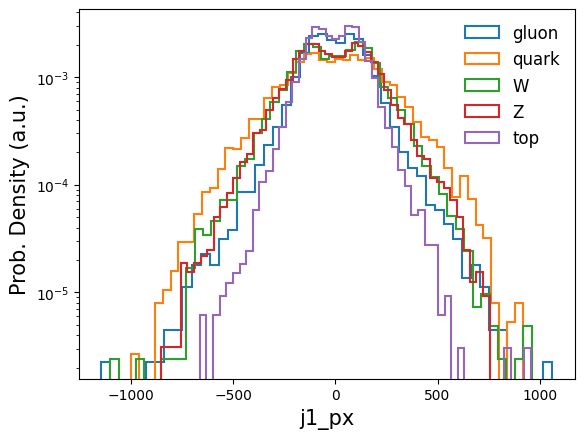

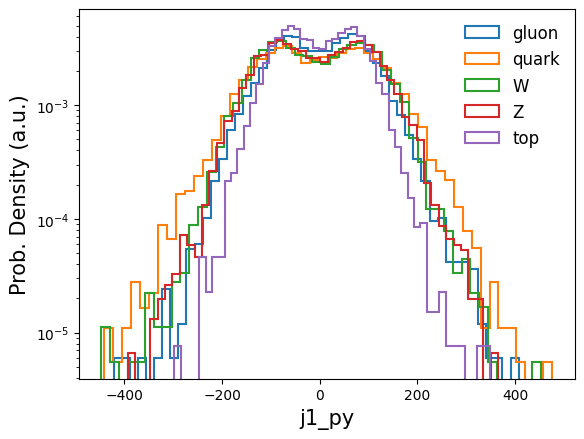

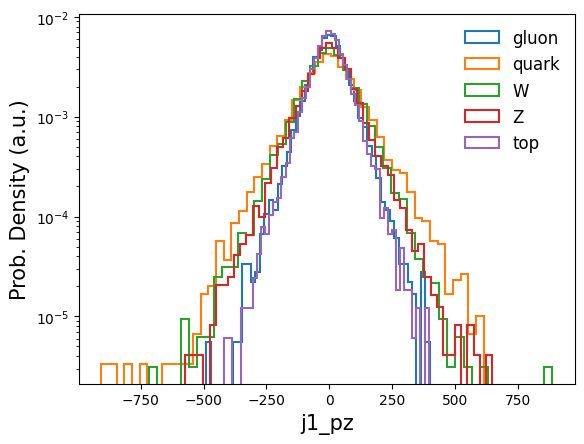

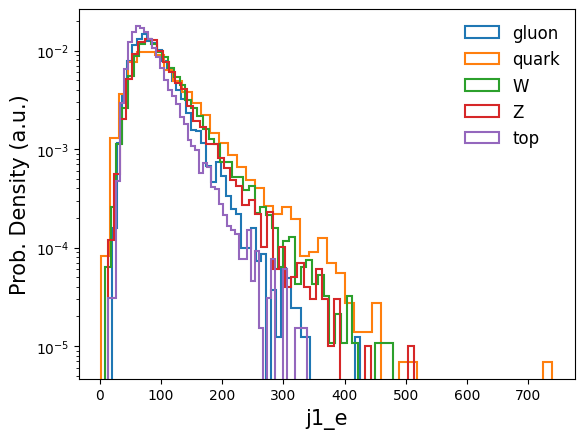

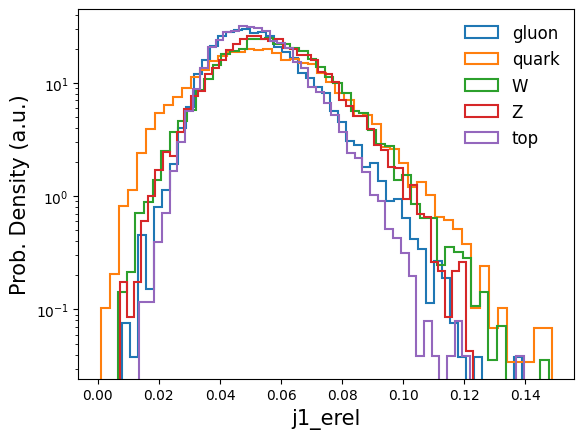

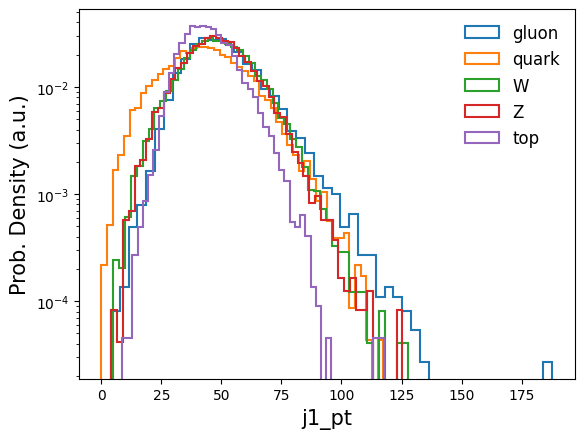

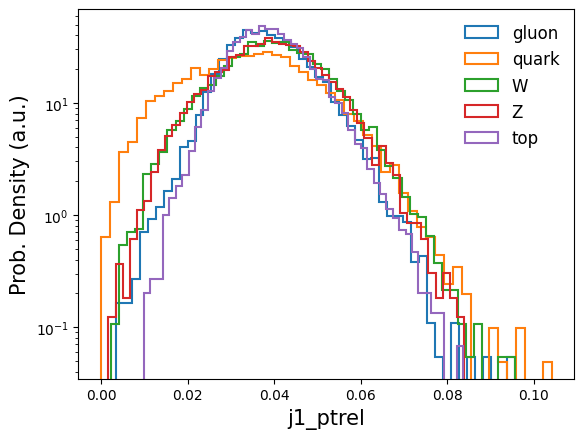

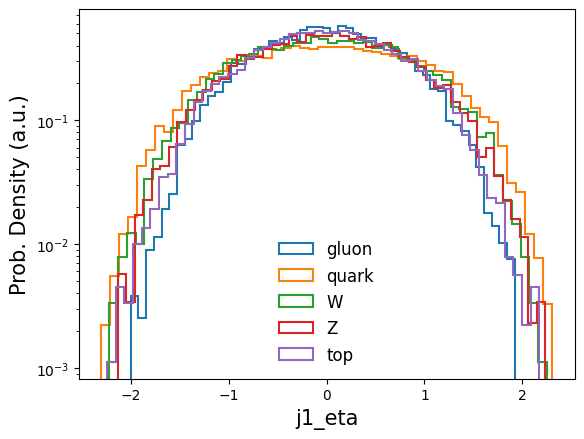

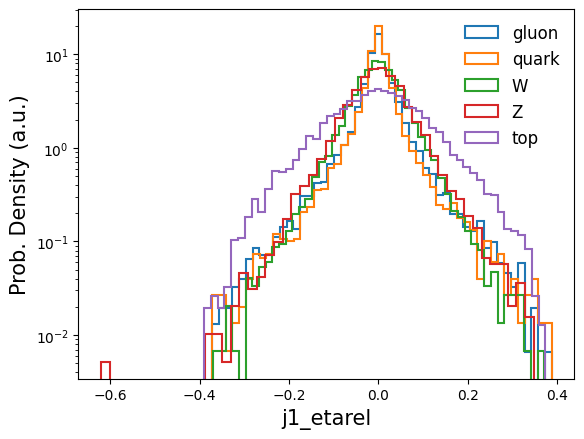

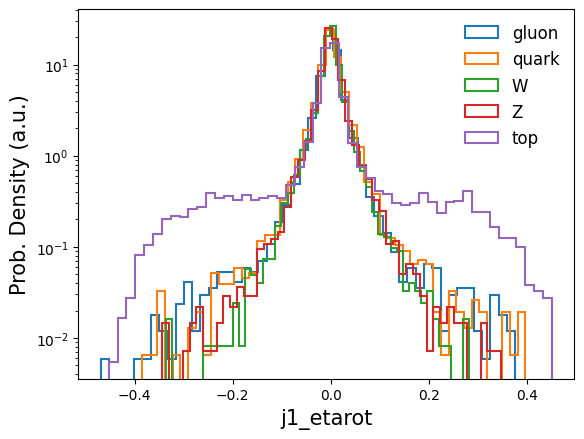

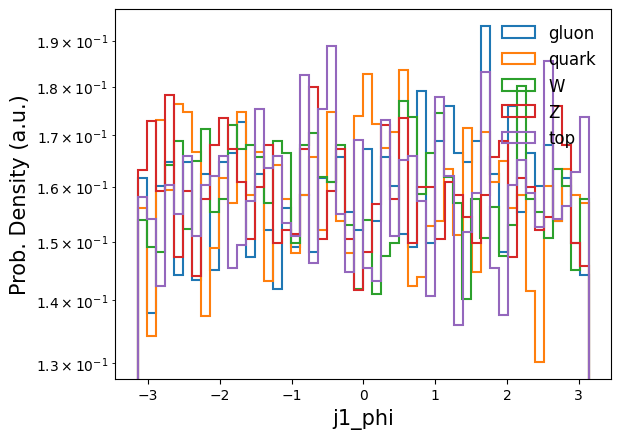

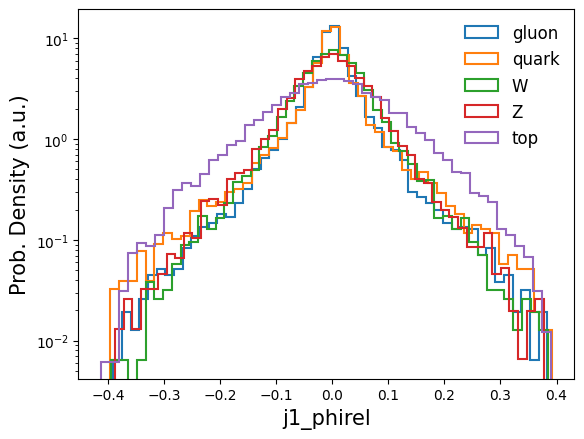

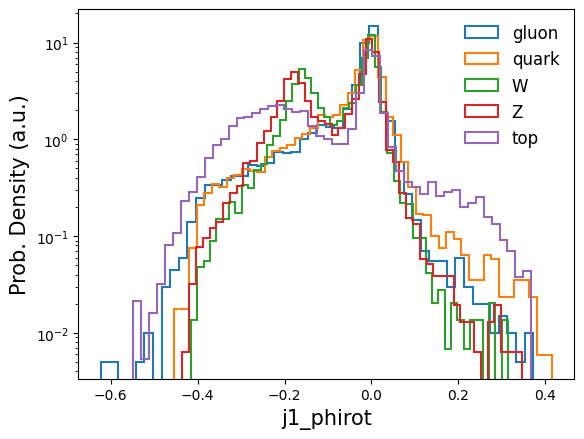

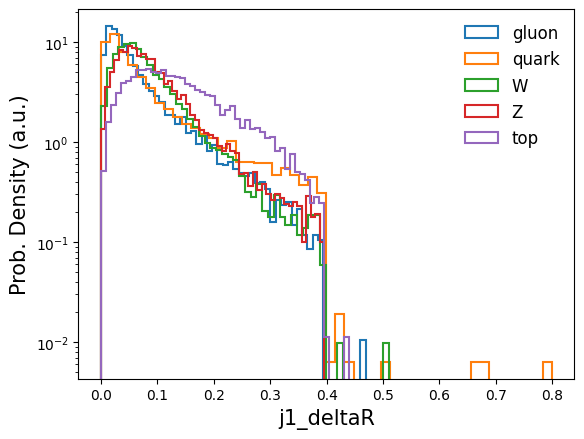

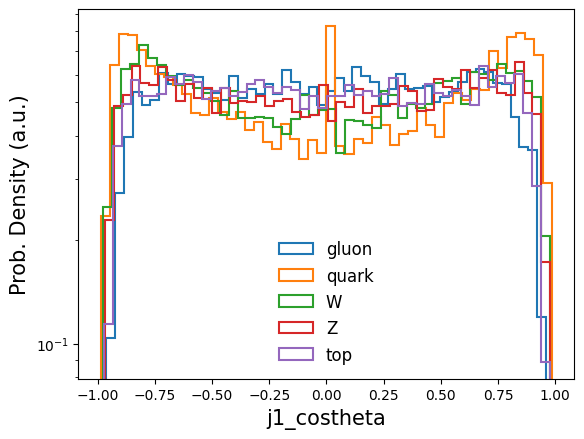

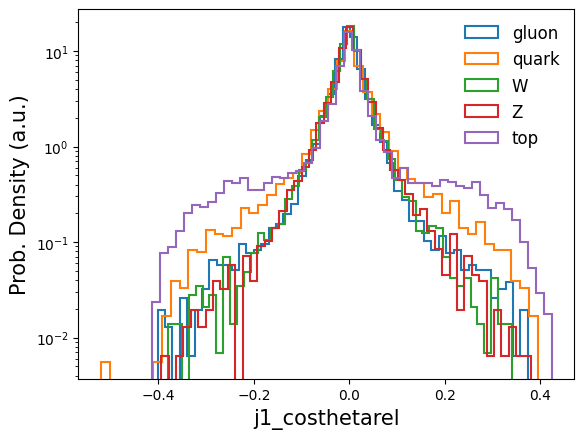

In [ ]:
# we now plot all the features
for i in range(len(p_featurenames)):
    makePlot_p(i, p_data, p_featurenames, labels)

Convert the target array in one-hot labels and split data

In [ ]:
# convert one-hot lables in integers labels, and split data

p_label = np.argmax(target, axis=1)

data_notnorm = np.array(p_data)

# training, validation, test split
from sklearn.model_selection import train_test_split
training_frac = 0.6 # training set fraction wrt whole sample
testset_frac = 0.25 # test set fraction wrt validation set

X_train,X_test,Y_train,Y_test = train_test_split(data_notnorm,p_label,train_size=training_frac, shuffle=True, random_state=1234)
X_vali,X_test,Y_vali,Y_test = train_test_split(X_test,Y_test,test_size=testset_frac, shuffle=True, random_state=1234)

print(X_train.shape)
print(X_vali.shape)
print(X_test.shape)
print(Y_train.shape)
print(Y_vali.shape)
print(Y_test.shape)

(30000, 100, 16)
(15000, 100, 16)
(5000, 100, 16)
(30000,)
(15000,)
(5000,)


Normalize input features in N(0,1), using *sklearn.preprocessing.StandardScaler*

In [ ]:
# normalize data

from sklearn.preprocessing import MinMaxScaler ,StandardScaler
scaler = StandardScaler()

#NOTE: StandardScaler works with (nevents, features) shaped arrays so let's convert (N, 100, 16) -> (N*100, 16) and back
X_train_norm = scaler.fit_transform(X_train.reshape(-1,X_train.shape[-1])).reshape(X_train.shape)
X_vali_norm = scaler.transform(X_vali.reshape(-1,X_vali.shape[-1])).reshape(X_vali.shape)
X_test_norm = scaler.transform(X_test.reshape(-1,X_test.shape[-1])).reshape(X_test.shape)
print(X_train_norm.shape)
print(X_vali_norm.shape)
print(X_test_norm.shape)

(30000, 100, 16)
(15000, 100, 16)
(5000, 100, 16)


Convert the numpy arrays in torch tensors using the *torch.Tensor(numpy vector).float()* or *.int()* methods


In [ ]:
# convert numpy arrays to torch tensors

data_tr = torch.Tensor(X_train_norm).float()
label_tr = torch.Tensor(Y_train).int()
data_va = torch.Tensor(X_vali_norm).float()
label_va = torch.Tensor(Y_vali).int()
data_te = torch.Tensor(X_test_norm).float()
label_te = torch.Tensor(Y_test).int()

print(data_tr.shape)
print(label_tr.shape)
print(data_va.shape)
print(label_va.shape)
print(data_te.shape)
print(label_te.shape)

torch.Size([30000, 100, 16])
torch.Size([30000])
torch.Size([15000, 100, 16])
torch.Size([15000])
torch.Size([5000, 100, 16])
torch.Size([5000])


Create torch dataset and dataloaders using *torch.utils.data.TensorDataset* and *torch.utils.data.DataLoader* methods

In [ ]:
# torch datasets
from torch.utils.data import TensorDataset

dataset_tr = TensorDataset(data_tr, label_tr)
dataset_va = TensorDataset(data_va, label_va)
dataset_te = TensorDataset(data_te, label_te)

print(len(dataset_tr))
print(len(dataset_va))
print(len(dataset_te))

30000
15000
5000


In [ ]:
# torch dataloader/batching
from torch.utils.data import DataLoader

batch=64 #batch size

train_loader = DataLoader(dataset_tr, batch_size=batch, shuffle=True, drop_last=True, pin_memory=True, num_workers=2)
val_loader = DataLoader(dataset_va, batch_size=batch, shuffle=False, drop_last=False, num_workers=2)
test_loader = DataLoader(dataset_te, batch_size=batch, shuffle=False, drop_last=False, num_workers=2)

print(len(train_loader))
print(len(val_loader))
print(len(test_loader))

468
235
79


## Transformer architecture

We define two python classes inheriting from pytroch nn.Module:

* *AttentionBlock*: implements the standard attention (multi-head attention + MLP) block for a tranformer encoder architecture
* *MyTransformer*: a classifier based on a transformer encoder architecture implementation

For the AttentionBlock the *mlp* head block is made by a Linear layer with GELU activation, a dropout layer, another Linear layer w/o activation followed by another dropout layer.

The *mlp* takes in input a tensor with dimension *embed_dim*, and output a tensor with the same dimension. The hidden layers have *hidden_dim* neurons. The two dropout layers uses the same *dropout* probability.

We'll use a nn.Sequential() model for the mlp containing nn.Linear, nn.GELU, nn.Dropout layers.

In [ ]:
class AttentionBlock(nn.Module):
    #  Implements the standard attention (multi-head attention + MLP) block for
    #  a tranformer encoder architecture

    #  structure:
    #   MHA: pre layer normalization (see Ruibin Xiong et al. (2020)) + multi-head attention (pytorch implementation) + layer normalization
    #   MLP: dense + gelu + droput + dense + dropout

    #  arguments:
    #   embed_dim  - Dimensionality of input and attention feature vectors
    #   hidden_dim - Dimensionality of hidden layer in feed-forward network
    #                (usually 2-4x larger than embed_dim)
    #   num_heads  - Number of heads to use in the Multi-Head Attention block
    #   dropout    - Amount of dropout to apply in the feed-forward network

    #    ^
    #    |_____    NOR2(x) + NOR2(MHA(NOR1(x))) + MLP(NOR2(MHA(NOR1(x)))): output (L,B,embde_dim)
    #    |     ^
    #  -----   |
    # | MLP |  |
    #  -----   |
    #    |_____|
    #    |
    #  -----
    # | NOR |
    #  -----
    #    |_____    x + MHA(NOR1(x))
    #    |     ^
    #  -----   |
    # | MHA |  |
    #  -----   |
    #    |     |
    #  -----   |
    # | NOR |  |
    #  -----   |
    #    |_____|
    #    |        x

    def __init__(self, embed_dim, hidden_dim, num_heads, dropout=0.0):
        super(AttentionBlock, self).__init__()

        self.layer_norm_1 = nn.LayerNorm(embed_dim)
        self.attn = nn.MultiheadAttention(embed_dim, num_heads) #this pytroch function implements a full MH-Attention block (see https://pytorch.org/docs/stable/generated/torch.nn.MultiheadAttention.html)
        self.layer_norm_2 = nn.LayerNorm(embed_dim)

        self.mlp = nn.Sequential(
            nn.Linear(embed_dim, hidden_dim),
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_dim, embed_dim),
            nn.Dropout(dropout)
        )

    def forward(self, x):
        inp_x = self.layer_norm_1(x)
        x = x + self.attn(inp_x, inp_x, inp_x)[0] #nn.MultiheadAttention expects input shapes 3x(L,B,F) and output
        x = self.layer_norm_2(x)
        x = x + self.mlp(x)
        return x

for the MyTransformer class the forward(self, x) method equence of operation on the input *x* are:
* project *x* into the embed_dim space
* apply dropout
* apply the transformer (remember to use *x.transpose(0, 1)* as the *nn.MultiheadAttention* expects input shape (L,B,F) and not (B,L,F)
* apply the mlp head for the classification

In [ ]:
class MyTransformer(nn.Module):
    #  Classifier based on a Transformer encoder architecture implementation

    #  structure:
    #   MHA: pre layer normalization (see Ruibin Xiong et al. (2020)) + multi-head attention (pytorch implementation) + layer normalization
    #   MLP: dense + gelu + droput + dense + dropout

    #  arguments:
    #   input_dim  - Dimensionality of input feature vectors (jet features)
    #   embed_dim  - Dimensionality of embedding in input to the Transformer
    #   hidden_dim - Dimensionality of hidden layer in feed-forward network
    #   num_heads  - Number of heads to use in the Multi-Head Attention block
    #   num_layers - Number of layers to use in the Transformer
    #   num_classes- Number of categories for the classification task
    #   dropout    - Amount of dropout to apply in the feed-forward network and in the input

    def __init__(self, input_dim, embed_dim, hidden_dim, num_heads, num_layers, num_classes, dropout=0.0):
        super(MyTransformer, self).__init__()

        # input layer (a dense MLP projecting the input in a embed_dim embedding space)
        self.input_layer = nn.Sequential(
            nn.Linear(input_dim,128),
            nn.GELU(),
            nn.Linear(128,512),
            nn.GELU(),
            nn.Linear(512,embed_dim),
            nn.GELU()
        )

        # Transformer encoder: stack of num_layers Attention Blocks (embed_dim -> embed_dim)
        self.transformer = nn.Sequential(*[AttentionBlock(embed_dim, hidden_dim, num_heads, dropout=dropout) for _ in range(num_layers)])

        # MLP Classifier (embed_dim -> num_classes)
        self.mlp_head = nn.Sequential(
            nn.LayerNorm(embed_dim),
            nn.Linear(embed_dim, num_classes)
        )

        self.dropout = nn.Dropout(dropout)


    def forward(self, x):
        # project input into the embed_dim space
        x = self.input_layer(x)

        # Apply Transformer
        x = self.dropout(x)
        x = x.transpose(0, 1) #note nn.MultiheadAttention expects input shapes 3x(L,B,F)
        x = self.transformer(x)

        # Classifier prediction
        cls = x[0] #take the ouput (the MH attention return output, attention weights)
        out = self.mlp_head(cls)
        return out

In [ ]:
# instantiate the model

# NOTE: embed_dim MUST be an integer multiple of num_heads
model_kwargs={
              'input_dim': 16,
              'embed_dim': 128,
              'hidden_dim': 256,
              'num_heads': 8,
              'num_layers': 8,
              'num_classes': 5,
              'dropout': 0.30
             }

model = MyTransformer(**model_kwargs)

In [ ]:
%pip install torchsummary

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


In [ ]:
# print model structure

print(model)

from torchsummary import summary
if torch.cuda.is_available():
  summary(model.cuda(), input_size=(100,16))
else:
  summary(model, input_size=(100,16))

MyTransformer(
  (input_layer): Sequential(
    (0): Linear(in_features=16, out_features=128, bias=True)
    (1): GELU(approximate='none')
    (2): Linear(in_features=128, out_features=512, bias=True)
    (3): GELU(approximate='none')
    (4): Linear(in_features=512, out_features=128, bias=True)
    (5): GELU(approximate='none')
  )
  (transformer): Sequential(
    (0): AttentionBlock(
      (layer_norm_1): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
      (attn): MultiheadAttention(
        (out_proj): NonDynamicallyQuantizableLinear(in_features=128, out_features=128, bias=True)
      )
      (layer_norm_2): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
      (mlp): Sequential(
        (0): Linear(in_features=128, out_features=256, bias=True)
        (1): GELU(approximate='none')
        (2): Dropout(p=0.3, inplace=False)
        (3): Linear(in_features=256, out_features=128, bias=True)
        (4): Dropout(p=0.3, inplace=False)
      )
    )
    (1): AttentionBlock(

**Exercise:** test the model on one batch to check everything is ok before training it

**Tipp:**
take one mini batch from the *train_loader* using *next(iter(loaeder))*, move model and tensors to GPU (using *tensor/model.to(device))*, test the model prediction with *model(input batch)*, and print the shape of the input and output

# Solution

In [ ]:
# test the model on one batch to check everything is ok before training it

model.to(device) #move the model on device (cpu/gpu)

xb,yb=next(iter(train_loader)) #take a mini batch from the trainign dataloader
xb=xb.type(torch.float).to(device) #move torch tensors to device (cpu or GPU)
yb=yb.type(torch.long).to(device)
print(xb.shape)
print(yb.shape)

out=model(xb) #apply the model on the input batch
print(out.shape)

torch.Size([64, 100, 16])
torch.Size([64])
torch.Size([64, 5])


# Training Procedure

We are now ready to complete the model by defining the loss function, the accuracy metric to monitor the training of the classifier, and the optmizer + learning rate scheduler.

Write two simple procedures to train and test the model on the training and test dataset, respectively.

If you are not new to PyTorch, this scheme should appear familiar to you. Otherwise, the PyTorch web site provides [a good introduction on how to train a neural network in PyTorch](https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html#define-a-loss-function-and-optimizer).


We'll use the trochmetrics library for the multiclass accuracy metric (*torchmetrics.classification.MulticlassAccuracy* method), to monitor averahe accuracy during training.

In [ ]:
#install torchmetrics: collection of useful PyTorch metrics implementations and an easy-to-use API to create custom metrics]
%pip install torchmetrics

Defaulting to user installation because normal site-packages is not writeable
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 805.2/805.2 kB 21.0 MB/s eta 0:00:0000:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 166.4/166.4 kB 20.4 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


In [ ]:
#loss
loss_func = nn.CrossEntropyLoss() #cross entropy loss

#metric accuracy from torchmetrics
import torchmetrics
from torchmetrics.classification import MulticlassAccuracy
metric_func = MulticlassAccuracy(num_classes=5)
metric_func = metric_func.to(device)

# optimizer + lr schedular
from torch import optim
opt = optim.Adam(model.parameters(), lr=1e-3)

# scheduler for step decay lr schedule
lr_scheduler = optim.lr_scheduler.MultiStepLR(opt, milestones=[20,30,35], gamma=0.2)

In [ ]:
#Checkpoints (to save model parameters during training)

# this is implemented by writing a python class that uses the torch.save method

class SaveBestModel:
    def __init__(self, best_valid_loss=float('inf')): #object initialized with best_loss = +infinite
        self.best_valid_loss = best_valid_loss

    def __call__(
        self, current_valid_loss,
        epoch, model, optimizer, criterion, metric,
    ):
        if current_valid_loss < self.best_valid_loss:
            self.best_valid_loss = current_valid_loss
            print(f"\nBest validation loss: {self.best_valid_loss}")
            print(f"\nSaving best model for epoch: {epoch+1}\n")
            # method to save a model (the state_dict: a python dictionary object that
            # maps each layer to its parameter tensor) and other useful parametrers
            # see: https://pytorch.org/tutorials/beginner/saving_loading_models.html
            torch.save({
                'epoch': epoch+1,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'loss': criterion,
                'metric': metric,
                }, 'best_model.pth')

In [ ]:
# in pytorch you are responsible of writing the training loop, this can be done by implementig specific
# python functions for the training and validation steps, or just, like in this example, by using a simple plain
# python loop

#training loop

epochs = 40 #number of epochs (~30"/epoch on T4 GPU in this hands-on)

import time

save_best_model = SaveBestModel() #initialize checkpoint function

# dfine python lists to save loss and metric history
hist_loss = []
hist_metric = []
hist_vloss = []
hist_vmetric = []

#loop over epochs
for epoch in range(epochs):
    t0 = time.time()

    #training step
    model.train()

    train_loss = 0.0
    train_metric = 0.0
    counter = 0
    for xb, yb in train_loader: #takes a batch from the train dataloader
        counter += 1
        xb=xb.type(torch.float).to(device) #move troch tensors to device (cpu or GPU)
        yb=yb.type(torch.long).to(device)

        pred = model(xb) #get prediction for batch
        loss = loss_func(pred, yb) #compute loss
        metric = metric_func(pred, yb) #compute accuracy

        train_loss += loss.item() #update total loss
        train_metric += metric.item() #update total metric

        # backpropagation
        loss.backward()
        # update weights
        opt.step()
        # set to zero gradients for the next step
        opt.zero_grad()

    # normalize loss and metric by number of batches
    train_loss = train_loss/(counter)
    train_metric = train_metric/(counter)

    # update history
    hist_loss.append(train_loss)
    hist_metric.append(train_metric)

    # evaluation step (same as training but w/o backpropagation)

    model.eval()

    vali_loss = 0.0
    vali_metric = 0.0
    counter = 0
    with torch.no_grad():
      for xb, yb in val_loader:
        counter += 1
        xb=xb.type(torch.float).to(device)
        yb=yb.type(torch.long).to(device)
        pred = model(xb)
        vloss = loss_func(pred, yb)
        vmetric = metric_func(pred, yb)
        vali_loss += vloss.item()
        vali_metric += vmetric.item()

    vali_loss = vali_loss/(counter)
    vali_metric = vali_metric/(counter)

    hist_vloss.append(vali_loss)
    hist_vmetric.append(vali_metric)

    #save best model
    save_best_model(vali_loss, epoch, model, opt, loss_func, metric_func)

    elapsed_time = time.time()-t0
    current_lr = lr_scheduler.get_last_lr()[0]
    print("epoch: %d, time(s): %.2f, train loss: %.6f, train metric: %.6f, vali loss: %.6f, vali metric: %.6f,  lr : %1.2e" % (epoch+1, elapsed_time, train_loss, train_metric, vali_loss, vali_metric,current_lr))

    # update learning rate schedule
    lr_scheduler.step()


Best validation loss: 1.2323051270018233

Saving best model for epoch: 1

epoch: 1, time(s): 41.94, train loss: 1.311351, train metric: 0.407171, vali loss: 1.232305, vali metric: 0.505534,  lr : 1.00e-03

Best validation loss: 0.9193643100718234

Saving best model for epoch: 2

epoch: 2, time(s): 41.44, train loss: 0.990306, train metric: 0.598317, vali loss: 0.919364, vali metric: 0.641667,  lr : 1.00e-03

Best validation loss: 0.876129506496673

Saving best model for epoch: 3

epoch: 3, time(s): 41.36, train loss: 0.897764, train metric: 0.653765, vali loss: 0.876130, vali metric: 0.673159,  lr : 1.00e-03

Best validation loss: 0.8579429169918629

Saving best model for epoch: 4

epoch: 4, time(s): 41.44, train loss: 0.857279, train metric: 0.682690, vali loss: 0.857943, vali metric: 0.681637,  lr : 1.00e-03
epoch: 5, time(s): 41.29, train loss: 0.802968, train metric: 0.705333, vali loss: 0.887594, vali metric: 0.677711,  lr : 1.00e-03

Best validation loss: 0.7559580276621148

Sav

**Exercise:** plot with matplotlib loss and accuracy VS #epochs for train and validation sets

# Solution

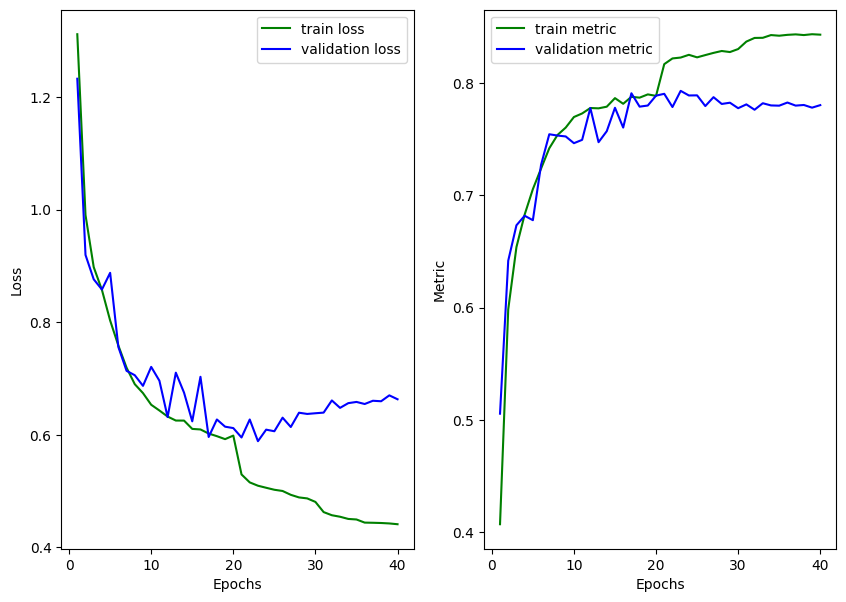

In [ ]:
# plot training results (loss and accuracy vs epoch)

plt.figure(figsize=(10, 7))
plt.subplot(1,2,1)
plt.plot(range(1,len(hist_loss)+1), hist_loss, color='green', linestyle='-', label='train loss')
plt.plot(range(1,len(hist_vloss)+1), hist_vloss, color='blue', linestyle='-', label='validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.subplot(1,2,2)
plt.plot(range(1,len(hist_metric)+1), hist_metric,  color='green', linestyle='-', label='train metric')
plt.plot(range(1,len(hist_vmetric)+1),hist_vmetric, color='blue', linestyle='-', label='validation metric')
plt.xlabel('Epochs')
plt.ylabel('Metric')
plt.legend()

# Load the best model

In [ ]:
# load the best model
checkpoint = torch.load('./best_model.pth')
print('Best model at epoch: ', checkpoint['epoch'])

model = MyTransformer(**model_kwargs)
model.load_state_dict(checkpoint['model_state_dict'])
model.eval()

Best model at epoch:  23


MyTransformer(
  (input_layer): Sequential(
    (0): Linear(in_features=16, out_features=128, bias=True)
    (1): GELU(approximate='none')
    (2): Linear(in_features=128, out_features=512, bias=True)
    (3): GELU(approximate='none')
    (4): Linear(in_features=512, out_features=128, bias=True)
    (5): GELU(approximate='none')
  )
  (transformer): Sequential(
    (0): AttentionBlock(
      (layer_norm_1): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
      (attn): MultiheadAttention(
        (out_proj): NonDynamicallyQuantizableLinear(in_features=128, out_features=128, bias=True)
      )
      (layer_norm_2): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
      (mlp): Sequential(
        (0): Linear(in_features=128, out_features=256, bias=True)
        (1): GELU(approximate='none')
        (2): Dropout(p=0.3, inplace=False)
        (3): Linear(in_features=256, out_features=128, bias=True)
        (4): Dropout(p=0.3, inplace=False)
      )
    )
    (1): AttentionBlock(

**Exercise:** loop over the test set and:
* compute the average accuracy
* save the predicted probability for each class in a torch tensor *pred_prob* of size *(test_set_events, 5)*
* save the predicted class in a torch tensor *pred_val* of size *(test_set_events,)*
* save the true class in in a torch tensor *ground_truth* of size *(test_set_events,)*

**Tipp:**
write a loop similar to the one used in the validation step of the training loop. Put tensors on GPU to speedup the computation.

NOTE:
* example to create an empty torch tensor on the GPU: *torch.empty(size=(0,5), device=device)*
* example on how to concatenate two torch tensors along first dimension: *torch.cat((pred_prob, pre), dim=0)*

# Solution

In [ ]:
# inference on test set
pred_prob = torch.empty(size=(0,5), device=device) #note the device parameter, this allows to create the torch tensors directly in the needed device
pred_val = torch.empty(size=(0,), device=device)
ground_truth = torch.empty(size=(0,), device=device)

model.to(device)

test_loss = 0.0
test_metric = 0.0

counter=0
with torch.no_grad():
  for xb, yb in test_loader:
    counter += 1
    xb=xb.type(torch.float).to(device)
    yb=yb.type(torch.long).to(device)
    res = model(xb)
    pre = torch.softmax(res, dim=1)
    val = pre.argmax(dim=1)
    pred_prob = torch.cat((pred_prob, pre), dim=0)
    pred_val = torch.cat((pred_val, val), dim=0)
    ground_truth = torch.cat((ground_truth, yb), dim=0)
    vloss = loss_func(res, yb)
    vmetric = metric_func(res, yb)
    test_loss += vloss.item()
    test_metric += vmetric.item()

test_loss = test_loss/(counter)
test_metric = test_metric/(counter)

predict_val = pred_val.cpu().data.numpy()
predict_prob = pred_prob.cpu().data.numpy()
true_val = ground_truth.cpu().data.numpy()

print('test loss: ', test_loss)
print('test average accuracy: ', test_metric)

test loss:  0.5837306663205352
test average accuracy:  0.7986540296409703


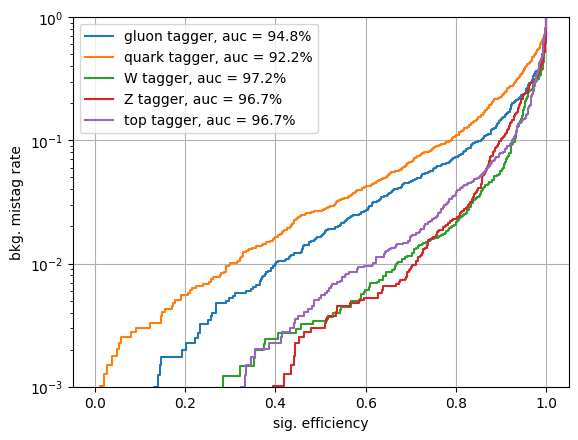

In [ ]:
from sklearn.metrics import roc_curve, auc

# print ROC curves
fpr = {}
tpr = {}
auc1 = {}
plt.figure()
for i, label in enumerate(labels):
        fpr[label], tpr[label], threshold = roc_curve((true_val==i), predict_prob[:,i])
        auc1[label] = auc(fpr[label], tpr[label])
        plt.plot(tpr[label],fpr[label],label='%s tagger, auc = %.1f%%'%(label,auc1[label]*100.))
plt.semilogy()
plt.xlabel("sig. efficiency")
plt.ylabel("bkg. mistag rate")
plt.ylim(0.001,1)
plt.grid(True)
plt.legend(loc='upper left')
plt.show()

In [ ]:
#function to print a formatted confusion matrix
def print_cm(cm, labels, hide_zeroes=False, hide_diagonal=False, hide_threshold=None):
    """pretty print for confusion matrixes"""
    columnwidth = max([len(x) for x in labels] + [5])  # 5 is value length
    empty_cell = " " * columnwidth
    # Print header
    print("    " + empty_cell, end=" ")
    for label in labels:
        print("%{0}s".format(columnwidth) % label, end=" ")
    print()

    # Print rows
    for i, label1 in enumerate(labels):
        print("    %{0}s".format(columnwidth) % label1, end=" ")
        for j in range(len(labels)):
            cell = "%{0}.2f".format(columnwidth) % cm[i, j]
            if hide_zeroes:
                cell = cell if float(cm[i, j]) != 0 else empty_cell
            if hide_diagonal:
                cell = cell if i != j else empty_cell
            if hide_threshold:
                cell = cell if cm[i, j] > hide_threshold else empty_cell
            print(cell, end=" ")
        print()

In [ ]:
# confusion matrix
from sklearn.metrics import confusion_matrix
c_mat = confusion_matrix(true_val, predict_val, normalize='true')
print("Confusion Matrix:")
print("")
print_cm(c_mat,labels)

Confusion Matrix:

          gluon quark     W     Z   top 
    gluon  0.76  0.09  0.02  0.02  0.11 
    quark  0.14  0.68  0.05  0.03  0.10 
        W  0.02  0.06  0.83  0.08  0.02 
        Z  0.03  0.08  0.03  0.85  0.02 
      top  0.06  0.02  0.02  0.02  0.88 


# Exercise:
try to write by hands the *nn.MultiheadAttention* layer

# Solution

In [ ]:
import math
import torch
import torch.nn as nn
import torch.nn.functional as F

class ScaledDotProductAttention(nn.Module):

    def forward(self, query, key, value, dropout=None):
        dk = query.size()[-1]
        scores = query.matmul(key.permute(0,1,3,2)) / math.sqrt(dk)

        if dropout is not None:
            scores = dropout(scores)

        attention = F.softmax(scores, dim=-1)

        return attention.matmul(value)


class MyMultiheadAttention(nn.Module):
    def __init__(self, embed_dim, num_heads, dropout = 0.0):
        super().__init__()

        self.embed_dim = embed_dim #total dimension of the model
        self.num_heads = num_heads #number of parallel attention heads (embed_dim will be slit across num_heads so that each head will have dimension embed_dim // num_heads)
        self.d_k = self.embed_dim // self.num_heads

        assert self.d_k * num_heads == self.embed_dim, "embed_dim must be divisible by num_heads"

        self.dropout = nn.Dropout(dropout)

        # q,v,k projectors
        self.q_linear = nn.Linear(embed_dim, embed_dim)
        self.k_linear = nn.Linear(embed_dim, embed_dim)
        self.v_linear = nn.Linear(embed_dim, embed_dim)

        # output projector
        self.out = nn.Linear(embed_dim, embed_dim)

    def forward(self, q, k, v, mask=None):

        batch_size, seq_len, _ = q.size() #batch size (q shape is (batch_size, seq_len, embed_dim))

        # produce qeury, key and value projections and split into num_heads heads
        # q,k,v have size: (batch_size, seq_len, embed_dim) #seq_len in our case is the number of particles per jet (100)
        qx = self.q_linear(q).view(batch_size, seq_len, self.num_heads, self.d_k)
        kx = self.k_linear(k).view(batch_size, seq_len, self.num_heads, self.d_k)
        vx = self.v_linear(v).view(batch_size, seq_len, self.num_heads, self.d_k)

        # permute to get dimensions batch_size, num_heads, seq_len, d_k
        qx = qx.permute(0,2,1,3)
        kx = kx.permute(0,2,1,3)
        vx = vx.permute(0,2,1,3)

        # calculate ScaledDopProduct attention
        scores = ScaledDotProductAttention()(qx, kx, vx, self.dropout)

        # concatenate heads
        concat = scores.permute(0,2,1,3).contiguous() #When you call contiguous(), it actually makes a copy of the tensor such that the order of its elements in memory is the same as if it had been created from scratch with the same data

        concat = concat.view(batch_size, seq_len, self.embed_dim) #output of MHA is again a tensor with shape (batch_size, seq_len, embed_dim) as was the input ....

        # pass it through the final linear layer
        output = self.out(concat)

        return output